In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj

In [4]:
path = '/work/users/jn906hluu/Climate/Precipitation'
list_of_datasets = [xr.open_dataset(os.path.join(file)) for file in os.scandir(path) if '.nc' in str(file)]

pr_ds = xr.concat(list_of_datasets, dim='time')

In [5]:
pr_ds

<xarray.Dataset>
Dimensions:             (time: 2252, bnds: 2, y: 1100, x: 1200)
Coordinates:
  * time                (time) datetime64[ns] 2018-01-01T18:00:00 ... 2019-12...
    lon                 (y, x) float64 3.427 3.441 3.454 ... 21.36 21.37 21.39
    lat                 (y, x) float64 45.29 45.29 45.29 ... 55.21 55.21 55.21
  * x                   (x) float32 3.5e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y                   (y) float32 2.1e+06 2.102e+06 ... 3.198e+06 3.2e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 2018-01-01T06:00:00 ... 2...
    x_bnds              (time, x, bnds) float32 3.5e+06 3.501e+06 ... 4.7e+06
    y_bnds              (time, y, bnds) float32 2.1e+06 2.101e+06 ... 3.2e+06
    crs_HYRAS           (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    pr                  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    number_of_stations  (time) float64 5.2e+03 5.201e+03 ... 5.276e+03 5.275e+03
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

In [6]:

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]

## The Problem: 

The grids are not rectangular in lat, lon as the earth is round and not flat. This is bad for us though, as we need the same "projection" of all our data to compare them. As I choose kind of a "flat earth" projection for the S2 data, we'll do the same here... 

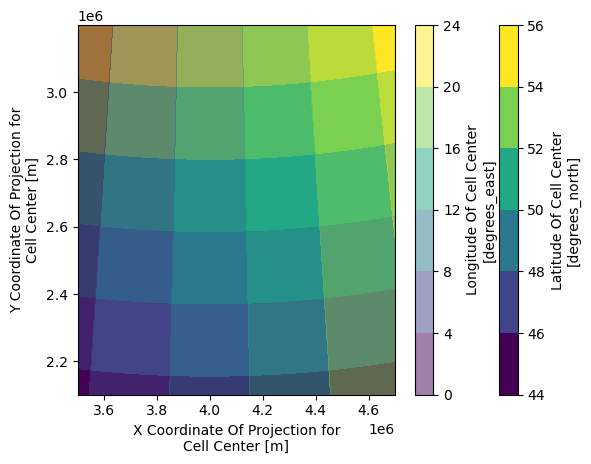

In [7]:
pr_ds.lat.plot.contourf()
pr_ds.lon.plot.contourf(alpha=0.5)

First make a box in which all the relevant data is masked. Lats and Lons which are inside the bounding box will be masked True. Then apply this mask with `.where()` to the Precipitation dataset and drop the NaNs (as `.where()` would return as the full shape of the object, but we're just interested in our region). Notice the option of `.dropna(dim=..., how='all)` where `how='all` only selects the rows/cols where ALL values are NaN.  

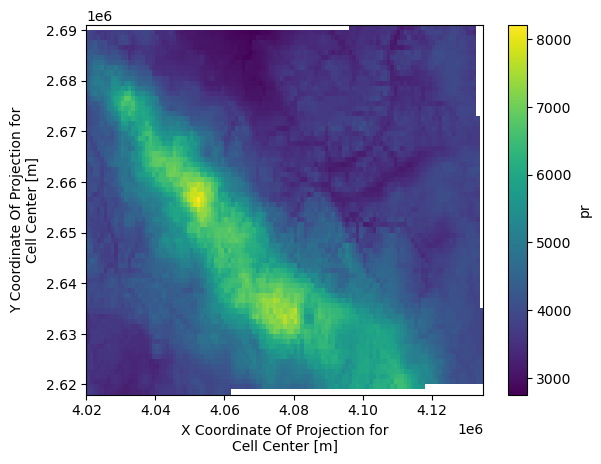

In [8]:
region_box = (pr_ds.lon < lon_max) & (pr_ds.lon > lon_min) & (pr_ds.lat < lat_max) & (pr_ds.lat > lat_min)
pr_sel = pr_ds.pr.sum(dim='time').where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all')
pr_sel.plot()


## Creating the new dataset

From here on it's kind of straight forward. Make an array where we mask all the precipitaion data accordingly to `region_box`, get the shapes of our dimensions and look for the lats & lons at the edges. Then make a new xarray Dataset with the data and that's it! 

In [10]:
pr_no_nan = np.array([pr_ds.pr.isel(time=i).where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all').values for i in range(len(pr_ds.time))])
dim_time, dim_y, dim_x = pr_no_nan.shape
pr_lat_max, pr_lat_min, pr_lon_min, pr_lon_max = pr_sel.lat[-1,0].values, pr_sel.lat[0,0].values, pr_sel.lon[-1,0].values, pr_sel.lon[0,-1].values

In [11]:
pr_reproject = xr.Dataset(
    data_vars= dict(
        pr = (['time', 'lat', 'lon'], pr_no_nan),
    ),
    coords= dict(
        time = pr_ds.time.values,
        lat = np.linspace(pr_lat_min, pr_lat_max, dim_y),
        lon = np.linspace(pr_lon_min, pr_lon_max, dim_x)
    )
)
pr_reproject

<xarray.Dataset>
Dimensions:  (time: 2252, lat: 73, lon: 115)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T18:00:00 ... 2019-12-31T18:00:00
  * lat      (lat) float64 50.31 50.32 50.33 50.34 ... 50.95 50.96 50.97 50.98
  * lon      (lon) float64 10.3 10.32 10.33 10.35 ... 11.91 11.93 11.94 11.95
Data variables:
    pr       (time, lat, lon) float32 7.1 6.9 6.4 6.1 5.7 ... 0.0 0.0 nan nan

## Plotting

Finally, a plot of the accumulated precipitation over the last 6 years. This was done to assure that the orientation of the dataset is right (north is in the top). This makes sense as we can cleary see the shape of the forest. 

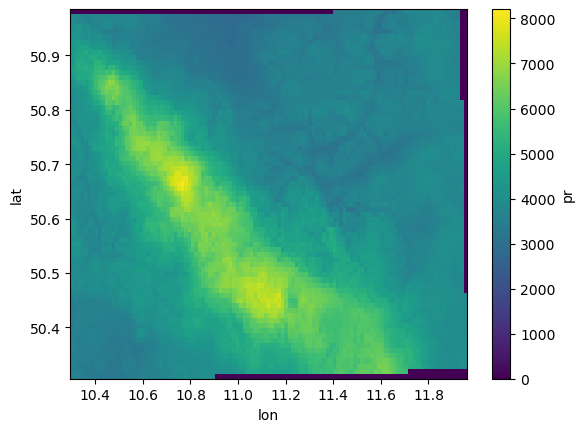

In [12]:
pr_reproject.pr.sum(dim='time').plot()

Saving the dataset as .zarr

In [13]:
#pr_reproject.to_zarr(path+'/precipitation.zarr')

## Temperature dataset 

The situation for the temperature dataset is a little different, as they are saved in asci :/, anyhow we can do it! First loading all the asci data with xarray, and giving them a datetime time index. 

In [18]:
list_of_temperature_datasets = [xr.open_dataset(os.path.join(file)) for file in os.scandir('/work/users/jn906hluu/Climate/Temperature/') if '.asc' in str(file)]

time_str = [os.path.join(file).split('_')[-1].split('.')[0] for file in os.scandir('/work/users/jn906hluu/Climate/Temperature/') if '.asc' in str(file)]
time_dt = [datetime.strptime(date_string, '%Y%m') for date_string in time_str]

new_T_ds = [list_of_temperature_datasets[i].assign_coords(time=np.datetime64(time_dt[i])) for i in range(len(time_dt))]

Now, let's take a look at the new dataset. 

In [19]:
new_T_ds[0]

<xarray.Dataset>
Dimensions:      (band: 1, x: 654, y: 866)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.281e+06 3.282e+06 ... 3.933e+06 3.934e+06
  * y            (y) float64 6.103e+06 6.102e+06 ... 5.239e+06 5.238e+06
    spatial_ref  int64 ...
    time         datetime64[ns] 2017-10-01
Data variables:
    band_data    (band, y, x) float64 ...

Concat the dataset to one xarray Dataset and sort it by time. Also plot the mean air temperature over the last 6 years. There seems to be no real winters in germany anymore. 

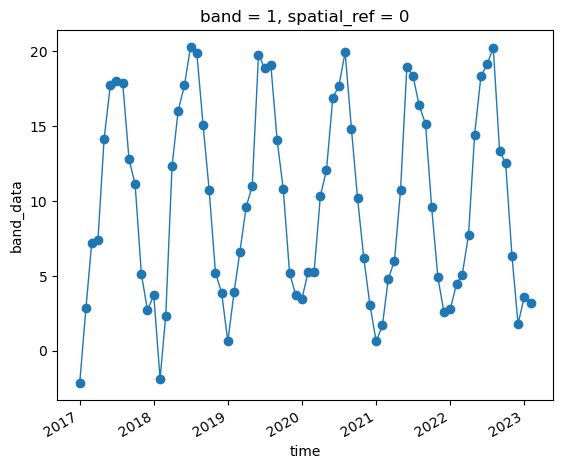

In [20]:
concat_ds = xr.concat(new_T_ds, dim='time')
concat_ds = concat_ds.sortby('time')

(concat_ds.band_data.mean(dim=['x', 'y']) / 10).plot(linewidth=1, marker='o')

# Here the actual transformation happens

Define the input coordinate system (CRS) `crs_in` and the outout CRS `crs_out`. Then build a transformer (which is nothing else than a `2x2` Matrix). Then we build a meshgrid (`https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html`) of our old coordinates `ds.x` and `ds.y`. Apply the function and they are transformed with the `transform_coordinates()` function. 

In [23]:

# Load the data into an xarray dataset
ds = concat_ds

# Define the input and output coordinate reference systems
crs_in = pyproj.CRS("EPSG:31467")
crs_out = pyproj.CRS("EPSG:4326")

# Create a PyProj transformer object
transformer = pyproj.Transformer.from_crs(crs_in, crs_out)

# Define a function to apply the transformer to the dataset's Northing and Easting variables
def transform_coordinates(easting, northing):
    lon, lat = transformer.transform(easting, northing)
    return lon, lat


Transform the dataset and have look at the orientation of the lats/lon! It seems to be the other way around. We have to take that into account when assing the final coordinates to the sliced dataset. 

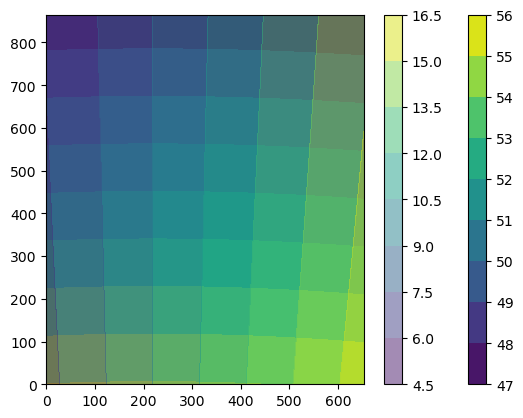

In [25]:
XX, YY = np.meshgrid(ds.x.values, ds.y.values)
lat, lon = transform_coordinates(YY, XX)

ds = ds.assign_coords(lon= (['y', 'x'],lon))
ds = ds.assign_coords(lat= (['y', 'x'],lat))
concat_ds = ds

plt.contourf(lat)
plt.colorbar()
plt.contourf(lon, alpha=0.5)
plt.colorbar()

Now, reiterate the same procedure as above. 

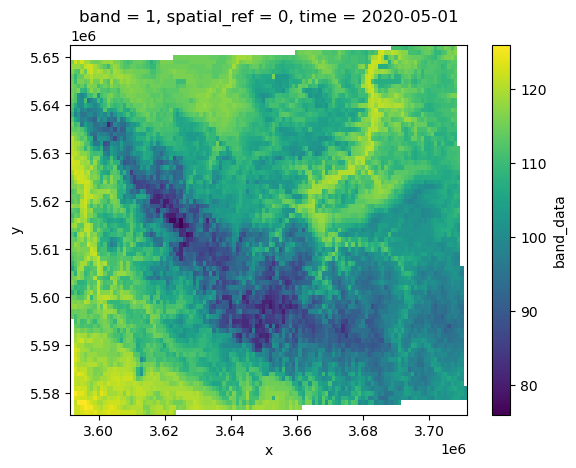

In [26]:
region_box = (concat_ds.lon < lon_max) & (concat_ds.lon > lon_min) & (concat_ds.lat < lat_max) & (concat_ds.lat > lat_min)
temperature_sel = concat_ds.band_data.isel(time=40).where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all')
temperature_sel.plot()

In [27]:
ts_no_nan = np.array([concat_ds.band_data.isel(time=i).where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all').values for i in range(len(concat_ds.band_data.time))])
dim_time, dim_y, dim_x = ts_no_nan[:,0,:,:].shape # dealing with the weird shape ...
ts_lat_max, ts_lat_min, ts_lon_min, ts_lon_max = temperature_sel.lat[-1,0].values, temperature_sel.lat[0,0].values, temperature_sel.lon[-1,0].values, temperature_sel.lon[0,-1].values

t_reproject = xr.Dataset(
    data_vars= dict(
        t = (['time', 'lat', 'lon'], ts_no_nan[:,0,:,:]),
    ),
    coords= dict(
        time = concat_ds.time.values,
        lat = np.linspace(pr_lat_max, pr_lat_min, dim_y),
        lon = np.linspace(pr_lon_min, pr_lon_max, dim_x)
    )
)
t_reproject

<xarray.Dataset>
Dimensions:  (time: 74, lat: 77, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2023-02-01
  * lat      (lat) float64 50.98 50.97 50.96 50.95 ... 50.34 50.33 50.32 50.31
  * lon      (lon) float64 10.3 10.32 10.33 10.34 ... 11.91 11.93 11.94 11.95
Data variables:
    t        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

## Plotting 

The forest should be colder, and that's exactly what we're seeing. Also it seems like you can see the river Saale and it's influence on the mean-air-temperature. Interesting...

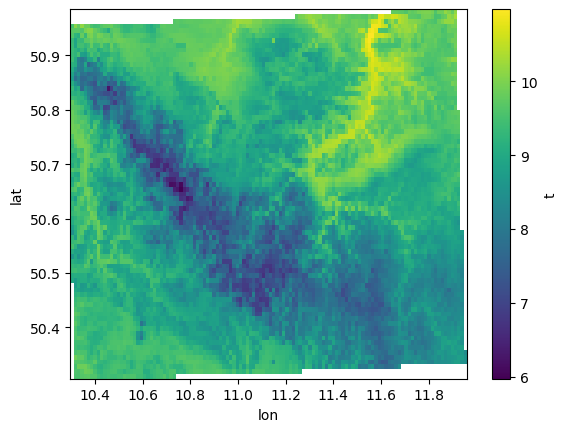

In [201]:
(t_reproject.t.mean(dim='time') / 10).plot()

#t_reproject.to_zarr('/work/users/jn906hluu/Climate/Temperature/temperature.zarr')

In [33]:
bbox = [10.294189,50.307024,11.961365,50.972242]

new_lat = np.linspace(bbox[3], bbox[1], 7530)
new_lon = np.linspace(bbox[0], bbox[2], 11540)

t_reproject.interp(lat=new_lat, lon=new_lon)

TODO: 

- make a folder at SC-Cluster and download precipitation and temperature raw_data from the DWD HYRAS model at ```https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/``` wit hthe `wget` command. 
- convert them with the above procedure and save them as `.zarr` somewhere. 
- For soil moisture this could be a little bit trickier, as these are .ascii files. Though the conversion shouldn't be too hard as they are in Easting/Northing. There should be rasterio function or something to convert them to WGS84. For more information, see `https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/soil_moist/The_1km_file_of_DWD.pdf` 